# 1. 사전 세팅

In [ ]:
import warnings
warnings.filterwarnings('ignore')

%cd "/content/drive/MyDrive/데이터 분석/projects/ML_protfoilo/7_pet_adoption_duration_analysis"

# 2. 문제 정의

---

    애완 동물은 어느 순간부터 우리의 가족과도 같은 존재가 되었지만, 이 순간에도 많은 사람들이 애완동물을 유기하기도 한다.
    그래서 분양된 동물들의 데이터를 분석해 어떤 동물들이 분양이 잘 되는지 분석해보고자 한다.
    예로, 통제 가능한 변수(백신, 중성화, 사진 수 등)의 영향도 분석으로 어떤 분양 프로필을 작성하는 것이 분양에 도움이 되는지도 알아보고자 한다.

# 3. 데이터 간단 확인

## 3.1. 데이터 명세

---

| Column | Description |
| :------------------ | :------------------------- |
| `Type`         | 애완동물 종류 (1: 개, 2: 고양이) |
| `Age`            | 나이 |
| `Breed1`           | 견종, 묘종  |
| `Color1`         | 첫번째 색깔                  |
| `Color2`              | 두번째 색깔                |
| `MaturitySize`        | 크기(1: 소형, 2: 중형, 3: 대형, 4: 초대형, 0: 정의 X)    |
| `FurLength`       | 털 길이(1: 짧은, 2: 중간, 3: 긴, 0: 정의 X) |
| `Vaccinated`         | 백신 접종 여부           |
| `Sterilized`    | 중성화 여부               |
| `Health`          | 건강 상태(1: 건강함, 2: 약간 아픔, 3: 많이 아픔, 0: 정의 X)                   |
| `Fee` | 분양 비용         |
| `Description` | 애완동물에 대한 설명         |
| `PhotoAmt` | 업로드된 애완동물의 전체 사진 수     |
| `AdoptionSpeed` | 분양된 속도. 작을수록 빨리 분양된 것, 4: 분양되지 않음       |

## 3.2. 데이터 가공 명세

---

| 명세 | 내용 |
|:----|:----|
| 가공 범위 | <input type="checkbox" checked> Feature(Column) 변형<br> <input type="checkbox">기간 단위 데이터 분석 및 Big Volume 특성을 반영하기 위한 데이터 증강<br> <input type="checkbox" checked>다양한 Table을 참조하기 위한 데이터 분할|
| 가공 상세 | <b>Feature(Column) 변형</b><br><br>- Object 자료형의 데이터를 Categorical 자료형으로 변환<br>- SMD(Standardized Mean Difference)를 통한 데이터 표준화<br><br><b>데이터 분할</b><br><br>- 검증을 위해 학습 데이터 80%, 검증 데이터 20%로 분할 |
| 가공 결과 | <b>As is</b><br><br>- row: 11537 / column: 15 / table: 1<br><br> <b>To be</b><br><br>- row: 11528(-9) / column: 47(+32) / table: 1  |

## 3.3. 데이터 살펴보기

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('Data/petfinder-mini.csv')
df.head()

In [ ]:
df.info()



```
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11537 entries, 0 to 11536
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Type           11537 non-null  object
 1   Age            11537 non-null  int64
 2   Breed1         11537 non-null  object
 3   Gender         11537 non-null  object
 4   Color1         11537 non-null  object
 5   Color2         11537 non-null  object
 6   MaturitySize   11537 non-null  object
 7   FurLength      11537 non-null  object
 8   Vaccinated     11537 non-null  object
 9   Sterilized     11537 non-null  object
 10  Health         11537 non-null  object
 11  Fee            11537 non-null  int64
 12  Description    11528 non-null  object
 13  PhotoAmt       11537 non-null  int64
 14  AdoptionSpeed  11537 non-null  int64
dtypes: int64(4), object(11)
memory usage: 1.3+ MB
```



## 3.4. Category Column으로 사용할 수 있는 변수 탐색

In [ ]:
df.select_dtypes(include=np.number).columns.tolist()

In [ ]:
for col in df.columns.tolist():
    print(f'{col}: {df[col].astype('category').cat.codes.nunique()}')

# 4. 문제 해결 프로세스 정의

---

▸ 문제

    애완동물의 수요가 많아지는만큼 유기되고 있는 애완동물의 수도 점점 많아지고 있다.
    유기된 동물들은 동물보호단체에서 구조해 새로운 가족을 찾는 이들에게 입양해주고 있따.

    1. As-Is
    구조된 동물의 나이, 종, 색깔 등의 다양한 정보와 사진을 이용해 프로필을 작성하고 입양 희망자가 있는 경우,
    일련의 절차를 거쳐 입양하는 과정을 거친다.

    2. To-Be
    어떠한 특성을 가진 동물들이 입양이 잘 되는지에 대해 분석하고,
    통제할 수 없는 변수와 통제 가능한 변수를 분류해 원활한 입양이 되기 위해 어떤 프로필을 적는 것이 좋은지도 알아낸다.

    3. Goal
    특성에 따른 입양 가능 예측 모델, 통제 가능한 변수에 대한 최적값 탐색
    
▸ 기대 효과

    애완동물의 색깔, 종, 나이와 같이 통제가 불가능한 변수의 경우에는 결과에 영향을 미칠 수 있도록 변경이 불가능하다.
    그러나, 프로필에 포함된 사진의 수와 같이 통제 가능 변수 분석으로 프로필 내 사진 개수의 최적값을 찾을 수 있다.

▸ 해결 방안

    object 자료형의 경우에는 보통 학습 알고리즘에 대부분 사용되기 어렵기에 수치형으로 변형
    Linear Model 및 tensorflow의 Neural Network 구조를 통한 모델링

▸ 성과 측정

    애완동물 입양 가능 확률

▸ 현업 적용

    Binary Classification 문제에서의 다양한 알고리즘 적용

# 5. 데이터 확인

## 5.1. 필요한 라이브러리 Import

In [ ]:
from datetime import datetime
from math import exp
from collections import defaultdict

# Manage data and statistics
import numpy as np
from numpy.random import default_rng, SeedSequence
import pandas as pd
from pandas.api.types import CategoricalDtype

from scipy import stats
from scipy.special import expit, logit
from scipy.stats.mstats import winsorize
from scipy.interpolate import interp1d, make_interp_spline, BSpline

# Plot Data
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
mpl.style.use('tableau-colorblind10')

import seaborn as sns
sns.set_style('white')
sns.set_context('notebook')

from IPython.display import HTML, Image, display, Markdown as md

# statsmodels
import patsy
from patsy import dmatrices
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

# scikit-learn
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

# tensorflow
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

## 5.2. 데이터 정보 확인

In [ ]:
df = pd.read_csv('Data/petfinder-mini.csv')

In [ ]:
df.info()



```
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11537 entries, 0 to 11536
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Type           11537 non-null  object
 1   Age            11537 non-null  int64
 2   Breed1         11537 non-null  object
 3   Gender         11537 non-null  object
 4   Color1         11537 non-null  object
 5   Color2         11537 non-null  object
 6   MaturitySize   11537 non-null  object
 7   FurLength      11537 non-null  object
 8   Vaccinated     11537 non-null  object
 9   Sterilized     11537 non-null  object
 10  Health         11537 non-null  object
 11  Fee            11537 non-null  int64
 12  Description    11528 non-null  object
 13  PhotoAmt       11537 non-null  int64
 14  AdoptionSpeed  11537 non-null  int64
dtypes: int64(4), object(11)
memory usage: 1.3+ MB
```



    직장 서버에서 작업을 하는 경우가 대다수.
    특히, 가상 환경(Jupyter Hub 등)을 제공해주는 곳이 많은데, Docker로 할당받아 사용하는 경우가 많다.

    그러다 보니 데이터 사이즈를 보고 환경을 돌려야한다.
    큰 데이터로 작업하다보면, 커널이 죽는 경우가 자주 생기게 된다.

    지금은 메모리 환경에서 작업하다보니, 커널이 죽게 되면 작업 진행 상황이 무너질 수도 있다.

In [ ]:
df.shape



```
(11537, 15)
```



In [ ]:
df.dtypes

In [ ]:
df.select_dtypes(include=np.number).columns.tolist()



```
['Age', 'Fee', 'PhotoAmt', 'AdoptionSpeed']
```



In [ ]:
df.hist(figsize=(21, 9))
plt.show()

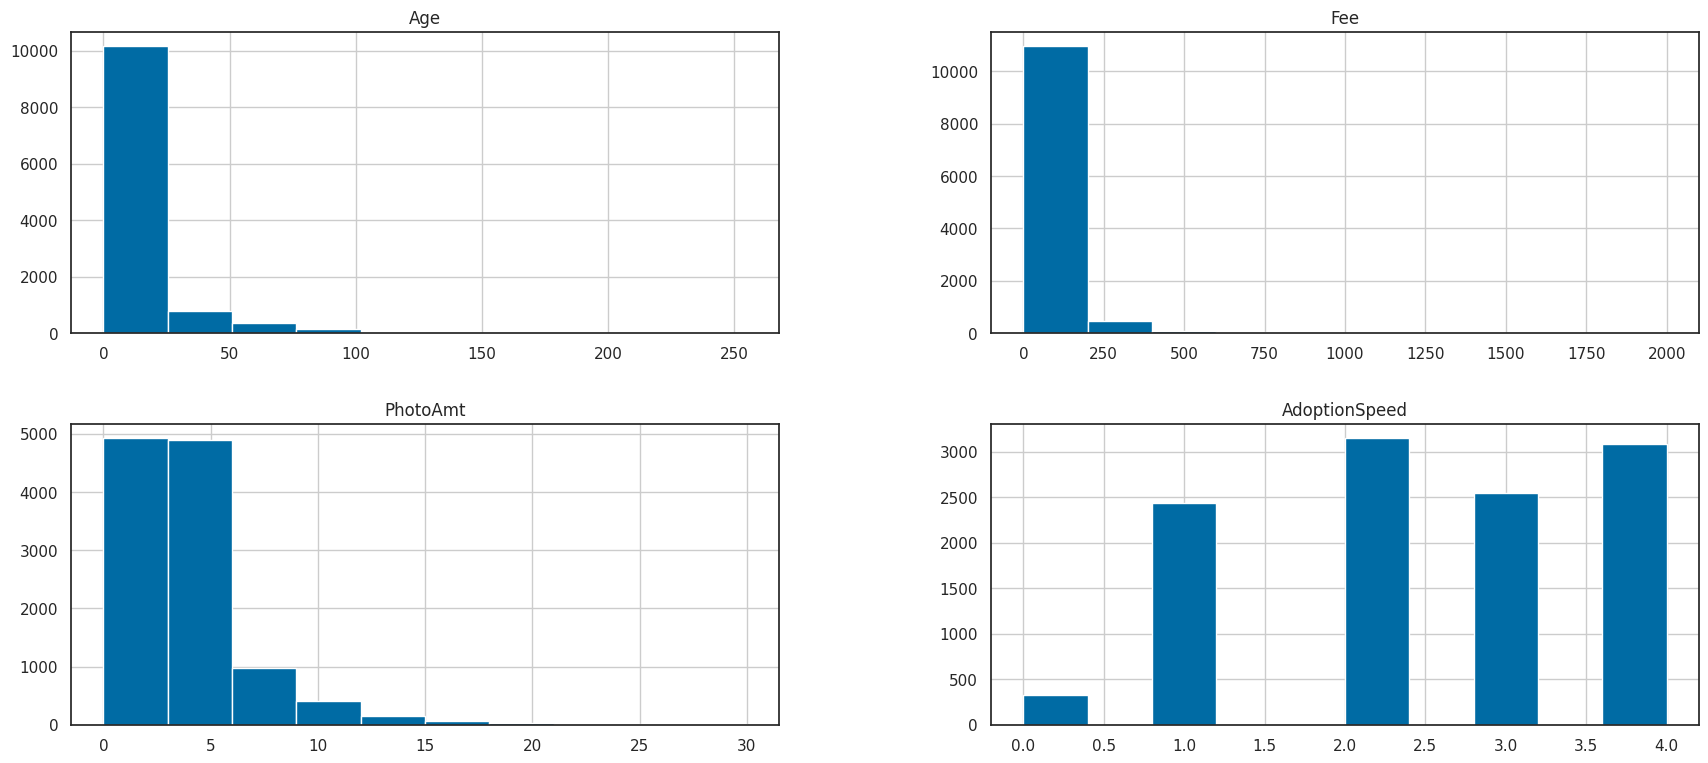

    환산이 되지 않은 나이가 있나?

In [ ]:
df['Age'].hist(figsize=(6, 4), bins=100)
plt.show()

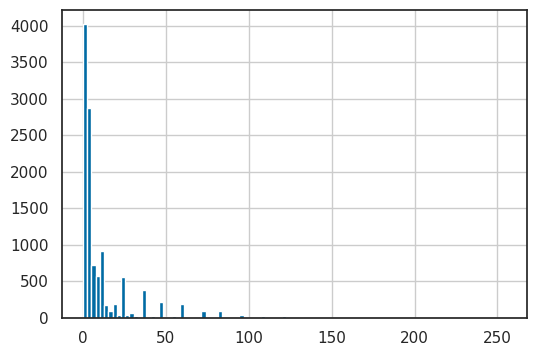

In [ ]:
df.describe().T.round(2)

In [ ]:
df.isna().sum()

# 6. Feature Engineering

## 6.1. 파생 변수 생성

In [ ]:
print(df['Description'].isna().sum())



```
9
```



In [ ]:
# 파생 변수를 만들기 위해 설명란이 결측인 데이터 행은 날리기
df = df.dropna(subset=['Description'])

# Binary 문제로 변형하기 위해, AdoptionSpeed가 4면, 입양 안 된 것, 그 외에는 된 것으로 변경
df['Adopted'] = np.where(df['AdoptionSpeed'] == 4, 0, 1)

# 설명으로도 무언가를 할 수 있을 듯하여 일단 파생 변수들 만들어보기
df['DescriptionLength'] = df['Description'].str.len()
df['WordCount'] = df['Description'].str.split().apply(len)
df['AvgWordLength'] = df['DescriptionLength'] / df['WordCount']

df = df.drop(columns=['AdoptionSpeed', 'Description'])
df.shape



```
(11528, 17)
```



In [ ]:
features = df.copy()
labels = features.pop('Adopted')

features.columns.tolist()



```
['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2',
 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee',
 'Description', 'PhotoAmt', 'DescriptionLength', 'WordCount', 'AvgWordLength']
```



In [ ]:
df.head()

## 6.2. Data Transformation

In [ ]:
features['IsCat'] = np.where(features['Type'] == 'Dog', 0, 1)

In [ ]:
features['IsFemale'] = np.where(features['Gender'] == 'Male', 0, 1)

In [ ]:
features['Vaccinated'].value_counts()

In [ ]:
# join에 on 옵션을 주지 않으면 인덱스 기준으로 Join하게 된다.
features = features.join(pd.get_dummies(features['Vaccinated'], prefix='Vaccinated', dtype=int))

In [ ]:
features['Sterilized'].value_counts()

In [ ]:
features = features.join(pd.get_dummies(features['Sterilized'], prefix='Sterilized', dtype=int))

In [ ]:
features = features.join(pd.get_dummies(features['Health'], prefix='Health', dtype=int))

In [ ]:
features['MaturitySize'].unique()



```
array(['Small', 'Medium', 'Large'], dtype=object)
```



In [ ]:
maturity_size_type = CategoricalDtype(categories=['Small', 'Medium', 'Large'], ordered=True)

In [ ]:
features['MaturitySize'] = features['MaturitySize'].astype(maturity_size_type)

In [ ]:
features['MaturitySize'].dtypes



```
CategoricalDtype(categories=['Small', 'Medium', 'Large'], ordered=True, categories_dtype=object)
```



In [ ]:
features = features.join(pd.get_dummies(features['MaturitySize'], prefix='MaturitySize', dtype=int))

In [ ]:
fur_length_type = CategoricalDtype(categories=['Short', 'Medium', 'Long'], ordered=True)
features['FurLength'] = features['FurLength'].astype(fur_length_type)
features = features.join(pd.get_dummies(features['FurLength'], prefix='FurLength', dtype=int))

In [ ]:
features['Color1'].unique()



```
array(['Black', 'Brown', 'Cream', 'Gray', 'Golden', 'White', 'Yellow'], dtype=object)
```



In [ ]:
features = features.join(pd.get_dummies(features['Color1'], prefix='Color1', dtype=int))
features = features.join(pd.get_dummies(features['Color2'], prefix='Color2', dtype=int))

### 6.2.1. Age는 어떻게 처리하나...

In [ ]:
len(features['Age'].unique())



```
105
```



In [ ]:
# 5분위수로 나누어 처리하자 !
ptile_labels = ['ptile1', 'ptile2', 'ptile3', 'ptile4', 'ptile5']
features = features.join(pd.get_dummies(pd.qcut(features['Age'], q=[0, .2, .4, .6, .8, 1], labels=ptile_labels), prefix='Age', dtype=int))
features.head()

## 6.2.2. Breed(종) 변수 처리

In [ ]:
features['Breed1'].value_counts()[:20]

In [ ]:
keep_breeds = ['Mixed Breed', 'Domestic Short Hair', 'Domestic Medium Hair',
               'Tabby', 'Domestic Long Hair', 'Siamese', 'Shih Tzu',
               'Persian', 'Labrador Retriever', 'Poodle', 'Terrier', 'Golden Retriever']

dd = defaultdict(lambda: 'Other')

for _, breed in enumerate(keep_breeds):
    dd[breed] = breed

In [ ]:
features = features.join(pd.get_dummies(features['Breed1'].map(dd), prefix='Breed1', dtype=int))

In [ ]:
categorical_predictors = ['Type', 'Gender', 'Age', 'Color1', 'Color2', 'MaturitySize',
                          'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1']

# 7. Data Readiness Check

## 7.1. Data Preprocessing

In [ ]:
print(len(list(features.columns)))



```
65
```



In [ ]:
list(features.columns)

In [ ]:
predictors = [
    # 'Type',
    # 'Age',
    # 'Breed1',
    # 'Gender',
    # 'Color1',
    # 'Color2',
    # 'MaturitySize',
    # 'FurLength',
    # 'Vaccinated',
    # 'Sterilized',
    # 'Health',
    # 'Fee',
    'PhotoAmt',
    'DescriptionLength',
    'WordCount',
    'AvgWordLength',
    'IsCat',
    'IsFemale',
    # 'Vaccinated_No',
    'Vaccinated_Not Sure',
    'Vaccinated_Yes',
    # 'Sterilized_No',
    'Sterilized_Not Sure',
    'Sterilized_Yes',
    'Health_Healthy',
    'Health_Minor Injury',
    'Health_Serious Injury',
    'MaturitySize_Small',
    'MaturitySize_Medium',
    'MaturitySize_Large',
    'FurLength_Short',
    'FurLength_Medium',
    'FurLength_Long',
    # 'Color1_Black',
    'Color1_Brown',
    'Color1_Cream',
    'Color1_Golden',
    'Color1_Gray',
    'Color1_White',
    'Color1_Yellow',
    'Color2_Brown',
    'Color2_Cream',
    'Color2_Golden',
    'Color2_Gray',
    # 'Color2_No Color',
    'Color2_White',
    'Color2_Yellow',
    'Age_ptile1',
    'Age_ptile2',
    'Age_ptile3',
    'Age_ptile4',
    # 'Age_ptile5',
    'Breed1_Domestic Long Hair',
    'Breed1_Domestic Medium Hair',
    'Breed1_Domestic Short Hair',
    'Breed1_Golden Retriever',
    'Breed1_Labrador Retriever',
    'Breed1_Mixed Breed',
    # 'Breed1_Other',
    'Breed1_Persian',
    'Breed1_Poodle',
    'Breed1_Shih Tzu',
    'Breed1_Siamese',
    'Breed1_Tabby',
    'Breed1_Terrier']

features = features[predictors].copy()

# SMD(표준화된 평균 차이)로 표준화
# 정규 분포에 가깝게 데이터를 표준화
features[predictors] = (features[predictors] - features[predictors].mean()) / features[predictors].std()

In [ ]:
features.head()

In [ ]:
# 데이터가 어떻게 변하는지 육안으로 계속 확인하는 것이 좋음
features.describe().T.round(2)

In [ ]:
features.hist(figsize=(21, 24))
plt.show()

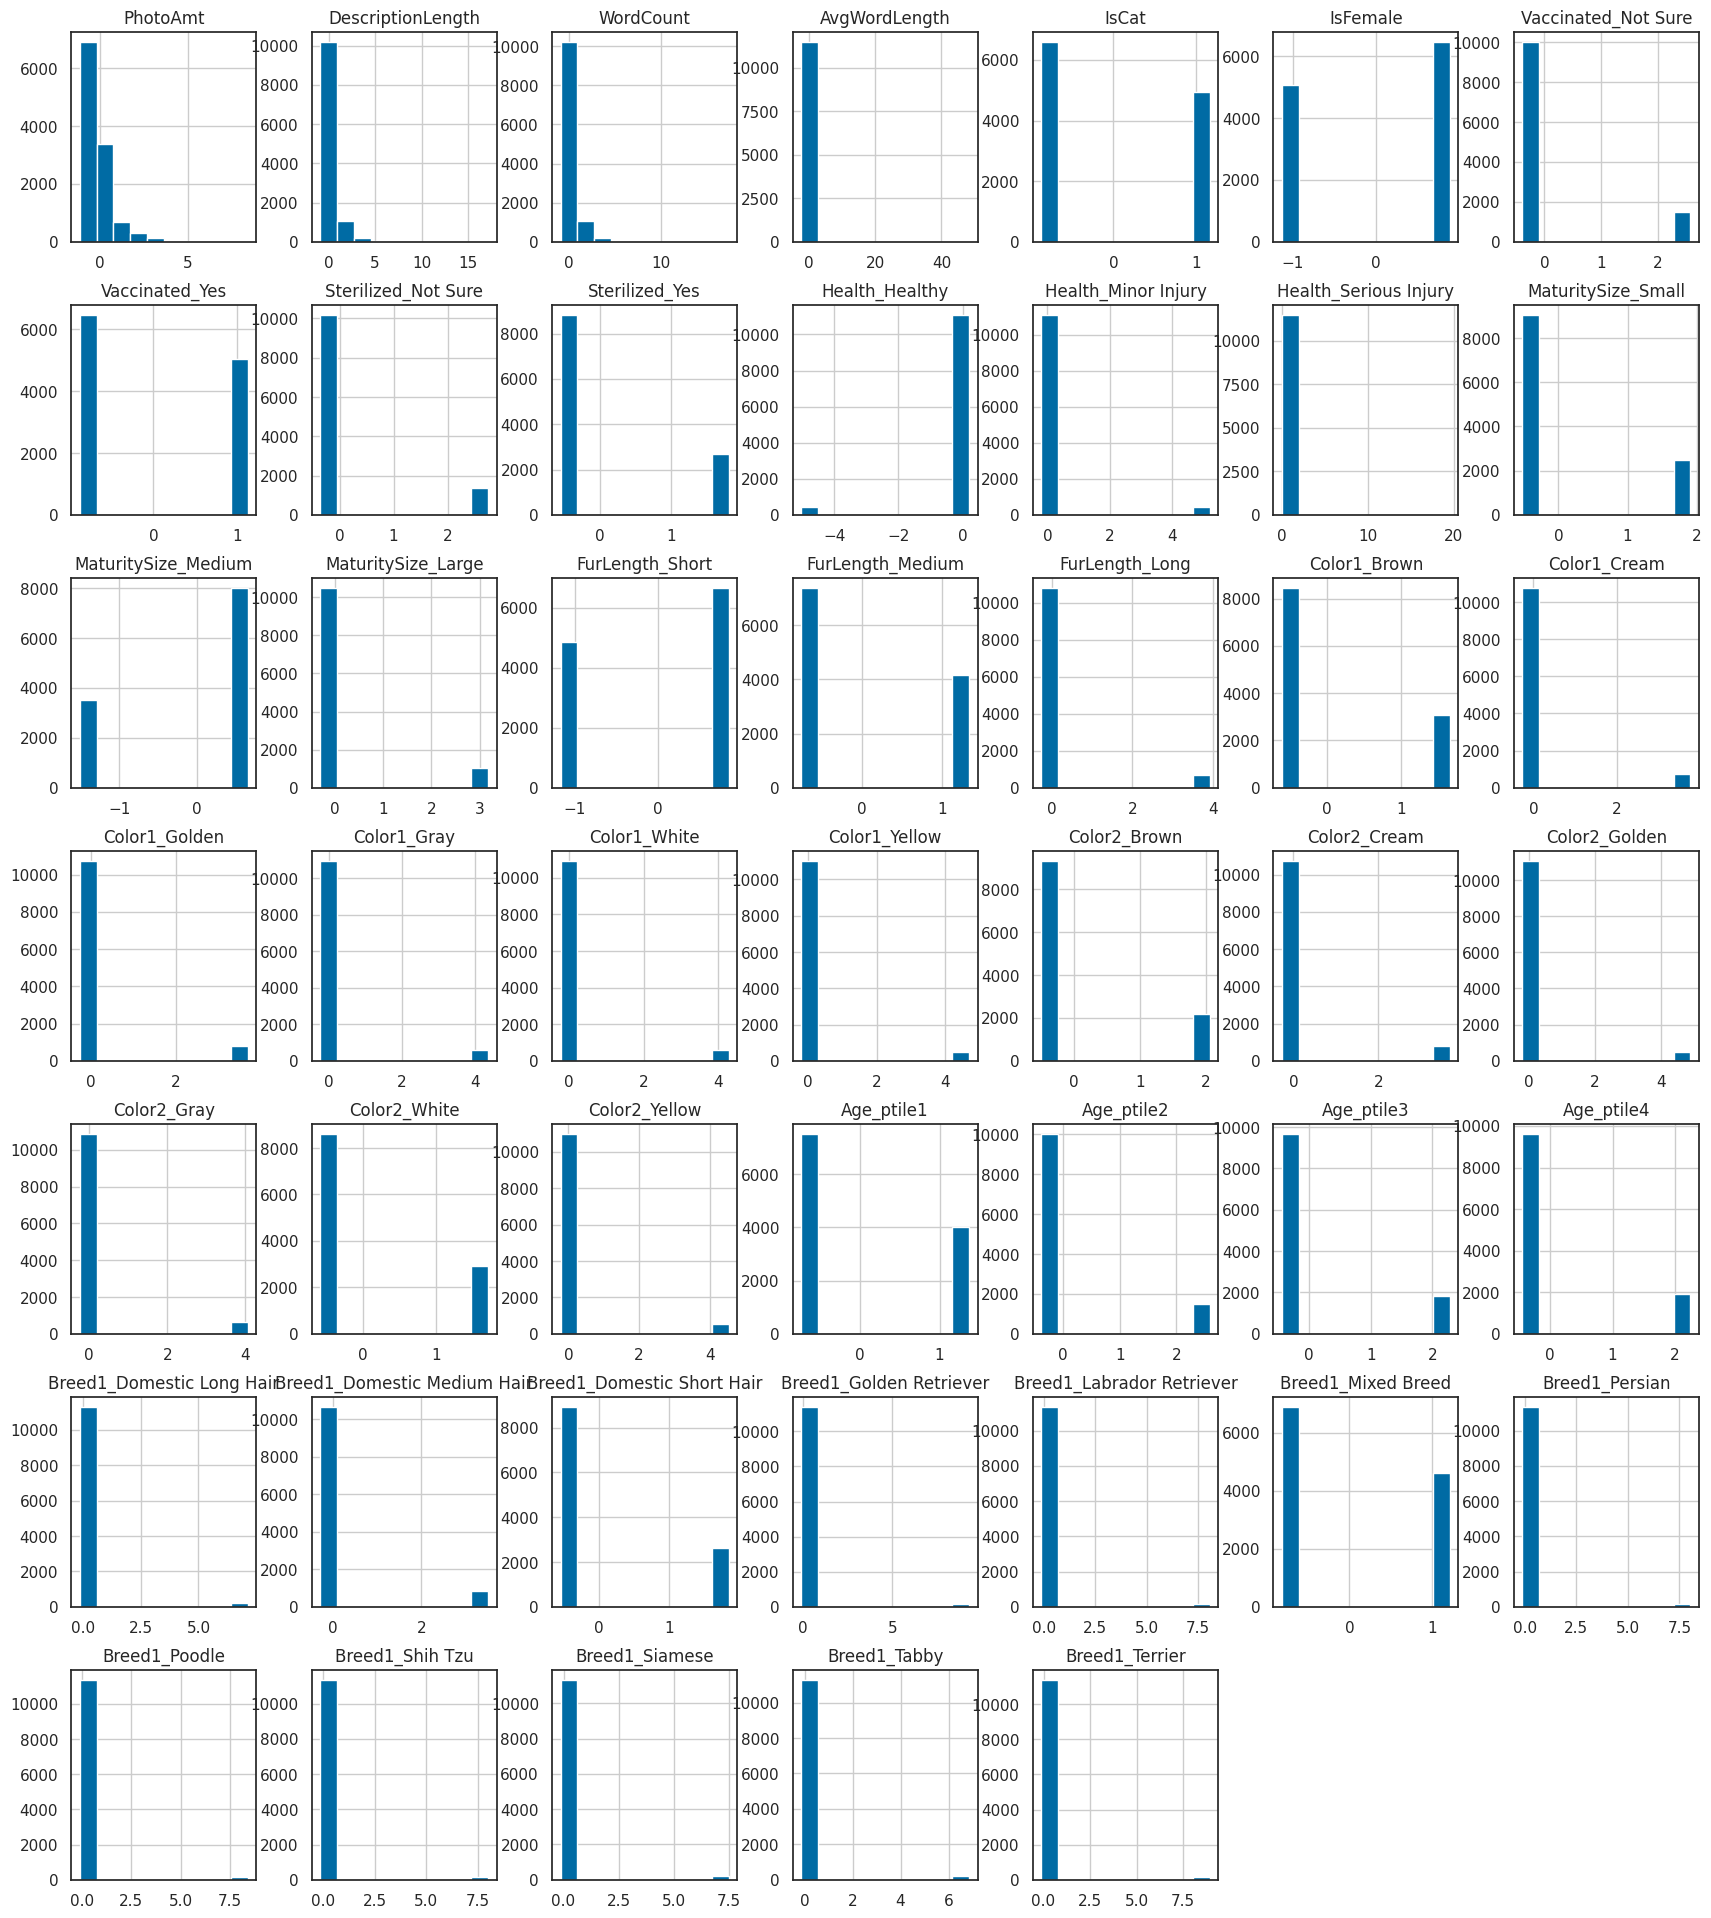

## 7.2. 데이터 분리

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=1234)

In [ ]:
X_train.shape, X_test.shape



```
((9222, 47), (2306, 47))
```



In [ ]:
g = sns.displot(X_train['PhotoAmt'], height=6, aspect=10/6)
g.set_axis_labels('Total uploaded photos for this pet (standardized)', '')
g.set_titles('')
plt.show()

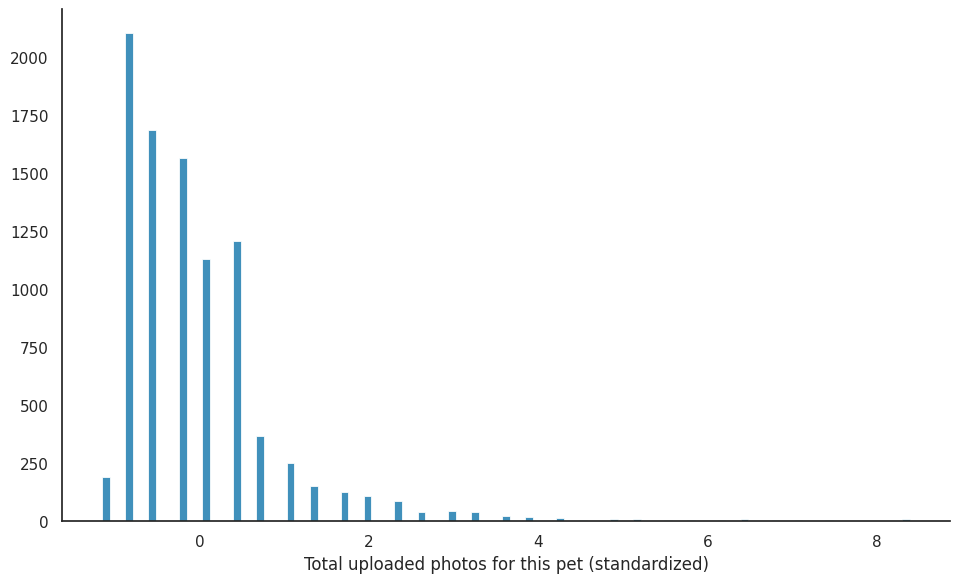

# 8. 모델링

## 8.1. statsmodels

In [ ]:
y = y_train.values

X = X_train['PhotoAmt'].values
# 상수항으로 만들기
X = sm.add_constant(X)

X.shape, y.shape



```
((9222, 2), (9222,))
```



In [ ]:
y[:5]



```
array([1, 1, 1, 1, 1])
```



In [ ]:
X[:5]



```
array([[ 1.        , -0.82988776],
       [ 1.        ,  0.4413405 ],
       [ 1.        , -0.19427363],
       [ 1.        , -0.82988776],
       [ 1.        , -0.51208069]])
```



In [ ]:
m1_sm = sm.Logit(y, X)
res_sm = m1_sm.fit()
print(res_sm.summary())



```
Optimization terminated successfully.
         Current function value: 0.574120
         Iterations 6
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 9222
Model:                          Logit   Df Residuals:                     9220
Method:                           MLE   Df Model:                            1
Date:                Thu, 06 Nov 2025   Pseudo R-squ.:                 0.01033
Time:                        11:54:41   Log-Likelihood:                -5294.5
converged:                       True   LL-Null:                       -5349.8
Covariance Type:            nonrobust   LLR p-value:                 7.486e-26
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0316      0.024     42.963      0.000       0.984       1.079
x1             0.2886      0.030      9.684      0.000       0.230       0.347
==============================================================================
```



In [ ]:
print(f'Parameters: {[float(np.round(val, 2)) for val in res_sm.params]}')
print(f'Standard Errors: {[float(np.round(val, 2)) for val in res_sm.bse]}')
print(f'Predicted Values: {[float(np.round(val, 2)) for val in res_sm.predict()[:10]]}')



```
Parameters: [1.03, 0.29]
Standard Errors: [0.02, 0.03]
Predicted Values: [0.69, 0.76, 0.73, 0.69, 0.71, 0.88, 0.74, 0.69, 0.76, 0.76]
```



In [ ]:
pd.concat([pd.Series(res_sm.predict(X)), pd.Series(expit(res_sm.fittedvalues))], axis=1).rename({0: 'Predicted', 1: 'Inverse Logit(Fitted)'}, axis=1)

In [ ]:
res_sm_margeff = res_sm.get_margeff()
print(res_sm_margeff.summary())

    Marginal Effects란, 로지스틱 회귀의 비선형 성질을 고려하여, 특정 변수가 1 단위 증가할 때 예측 확률이 얼마나 변하는지를 나타내는 값
    다른 변수가 일정할 때 x1(사진 수)이 1 증가하면, 사건(즉, y=1일 확률)이 약 5.6%p 증가한다는 뜻 !!



```
        Logit Marginal Effects       
=====================================
Dep. Variable:                      y
Method:                          dydx
At:                           overall
==============================================================================
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0558      0.006      9.807      0.000       0.045       0.067
==============================================================================
```



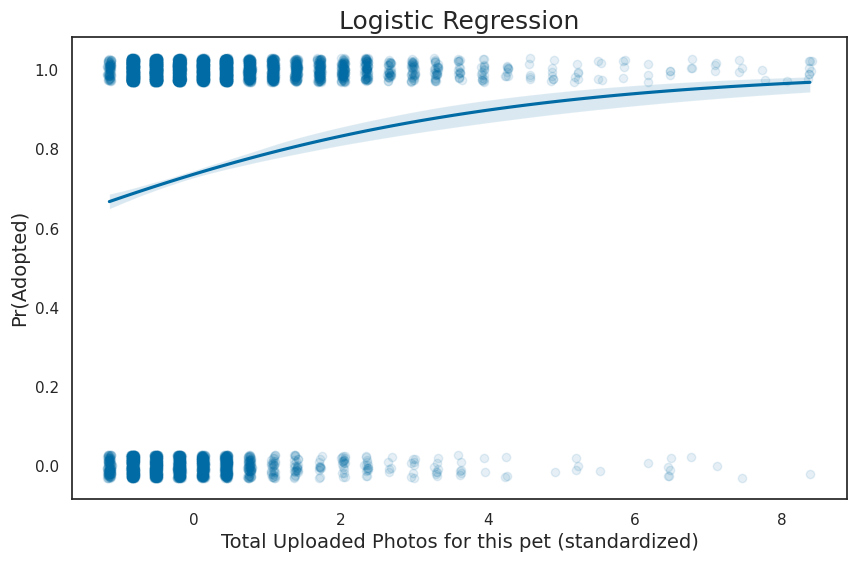

In [ ]:
def rand_jitter(arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

In [ ]:
x = np.linspace(X_train['PhotoAmt'].min(), X_train['PhotoAmt'].max(), 1000)
y = res_sm.predict(pd.DataFrame({'const': 1, 'PhotoAmt': x}))
f = interp1d(x, y, kind='cubic')
xnew = np.linspace(X_train['PhotoAmt'].min(), X_train['PhotoAmt'].max(), 1000)
ynew = f(xnew)

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(X_train['PhotoAmt'], rand_jitter(y_train), alpha=0.1, label='Data')
plt.plot(xnew, ynew, linestyle='-', color='black', label='Regression model')

ax.set_ylabel('Pr(Adopted)', fontsize=14)
ax.set_xlabel('Total Uploaded Photos for this pet (standardized)', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Logistic Regression', fontsize=18)

fig.tight_layout()
plt.show()

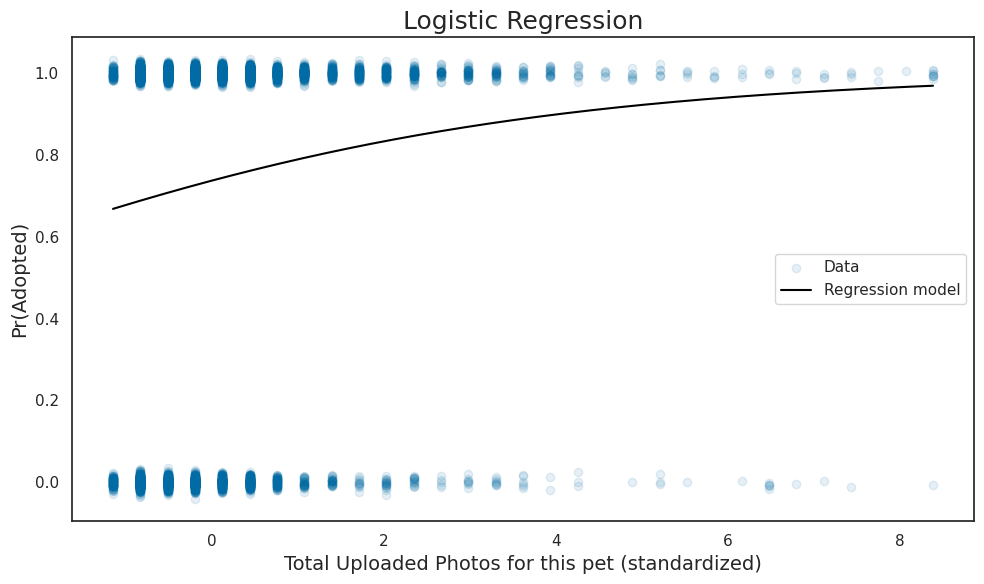